# CoVid 19

In [1]:
#importing libraries 

import pandas as pd
import numpy as np
import random
from sklearn import preprocessing
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#checking data

def load_data(data_path):
    df = pd.read_csv(data_path + '/patient.csv')
    df['released_date'] = pd.to_datetime(df['released_date'])
    df['confirmed_date'] = pd.to_datetime(df['confirmed_date'])
    df['month'] = df['confirmed_date'].dt.month
    df['day'] = df['confirmed_date'].dt.day
    return df

#checking France

df_france = load_data(r'C:\Users\Administrator\Desktop\DATA\Python Test Data\Final_CoVid_datasets\France')
df_france.isnull().sum()

id                  2067
sex                 1851
birth_year          1936
country                1
region                 1
departement          195
city                1804
group               1905
infection_reason    1906
infection_order     2068
infected_by         2056
contact_number      2073
confirmed_date         4
released_date       2064
deceased_date       2048
status              1481
health              1849
source               199
comments            1637
month                  4
day                    4
dtype: int64

In [3]:
df_france.head()

,id,sex,birth_year,country,region,departement,city,group,infection_reason,infection_order,...,contact_number,confirmed_date,released_date,deceased_date,status,health,source,comments,month,day
0,NaN,male,NaN,France,Nouvelle-Aquitaine,Charente-Maritime,NaN,NaN,contact with patient,NaN,...,NaN,2020-02-28,2020-02-03,NaN,released,NaN,CP ARS Nouvelle-Aquitaine,NaN,2.0,28.0
1,NaN,male,NaN,France,Nouvelle-Aquitaine,Gironde,NaN,NaN,visit to Italy,NaN,...,NaN,2020-02-28,NaT,NaN,hospital,good,CP ARS Nouvelle-Aquitaine,NaN,2.0,28.0
2,NaN,female,NaN,France,Nouvelle-Aquitaine,Landes,NaN,NaN,contact with patient,NaN,...,NaN,2020-02-28,NaT,NaN,hospital,good,CP ARS Nouvelle-Aquitaine,NaN,2.0,28.0
3,NaN,male,NaN,France,Nouvelle-Aquitaine,Pyrénées-Atlantiques,NaN,NaN,visit to Italy,NaN,...,NaN,2020-03-03,2020-03-06,NaN,released,good,CP ARS Nouvelle-Aquitaine,NaN,3.0,3.0
4,NaN,male,NaN,France,Nouvelle-Aquitaine,Lot-et-Garonne,NaN,Mulhouse religious gathering,visit to Mulhouse religious gathering,NaN,...,NaN,2020-03-05,NaT,NaN,home isolation,good,CP ARS Nouvelle-Aquitaine,NaN,3.0,5.0


In [4]:
# checking information on South Korea

df_south_korea = load_data(r'C:\Users\Administrator\Desktop\DATA\Python Test Data\Final_CoVid_datasets\South Korea')
df_south_korea.isnull().sum()

patient_id               0
global_num            1089
sex                     66
birth_year             437
age                     74
country                  0
province                 0
city                    79
disease               3308
infection_case         767
infection_order       3295
infected_by           2520
contact_number        2712
symptom_onset_date    2855
confirmed_date           3
released_date         2108
deceased_date         3266
state                    0
month                    3
day                      3
dtype: int64

In [5]:
df_south_korea.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,month,day
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,1.0,23.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released,1.0,30.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,1.0,30.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,1.0,30.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,1.0,31.0


In [6]:
#dropping certain columns

df_france.drop(['departement','region','comments', 'id', 'infected_by','health','city','source'],axis=1,inplace=True)
df_south_korea.drop(['province','disease','patient_id','infected_by'], axis=1, inplace=True)

In [7]:
#creating a function to simulate population's age based on available data

def simulate_age(ranges, percents, total_pop):
    simulated_pop = np.array(0)
    for (low, high), percent in zip(ranges, percents):
        simulated_pop = np.append(simulated_pop, 
                  np.random.randint(low=low, high=high, size=int(total_pop*percent/100)))
    return simulated_pop

In [8]:
france_population = 67364357

'''
0-14 years: 18.48% 
15-24 years: 11.8% 
25-54 years: 37.48% 
55-64 years: 12.42%
65 years and over: 19.82%
'''

ranges = [(0,14),(15,24),(25,54),(55,64),(65,90)]

percents = [18.48,11.8,37.48,12.42,19.82]

france_simulated_pop = simulate_age(ranges, percents, france_population)


# similarly for South Korea

'''
0-14 years: 13.03% 
15-24 years: 12.19%
25-54 years: 45.13%
55-64 years: 15.09% 
65 years and over: 14.55% 
'''

south_korea_population = 51418097
percents = [13.03,12.19,45.13,15.09,14.55]
south_korea_simulated_pop = simulate_age(ranges, percents, south_korea_population)



In [9]:
# creating an age column choosikng values from distribution created

import math
actual_year = pd.to_datetime('today').year
def calculate_age(x):
    if math.isnan(x):
        return x
    else:
        return int(actual_year - x)
    
#populations

france_population = 67364357

south_korea_population = 51418097
    
#France
df_france['age'] = df_france['birth_year'].apply(calculate_age)

df_france.fillna({'age':int(random.choice(france_simulated_pop))}, inplace=True)

df_france.drop(['birth_year'], axis=1, inplace=True)

#South Korea
df_south_korea['age'] = df_south_korea['birth_year'].apply(calculate_age)

df_south_korea.fillna({'age':int(random.choice(south_korea_simulated_pop))}, inplace=True)

df_south_korea.drop(['birth_year'], axis=1, inplace=True)
    
    

In [10]:
# gender column

'''
Considering m as men and w as women. 
m/w=ratio -> m=ration*w
m+w=total_pop
'''
def calculate_values(ratio, total_pop):
    w = (france_population/(1+ratio))/total_pop
    m = 1 - w
    return (w,m)

In [11]:
# 0 (woman) and 1 (man) with the calculated probabilities
# France
# total population: 0.96 male(s)/female (2018 est.)

w,m = calculate_values(0.96, france_population)

df_france['sex'] = df_france['sex'].str.lower()

df_france["sex"].replace({"male\xa0?": "male"}, inplace=True)

df_france.fillna({'sex': np.random.choice(['female','male'],p=[w,m])}, inplace=True)

In [12]:
# South Korea
# total population: 1 male(s)/female (2018 est.)
w,m = calculate_values(1, south_korea_population)

df_south_korea['sex'] = df_south_korea['sex'].str.lower()

df_south_korea["sex"].replace({"male\xa0?": "male"}, inplace=True)

df_south_korea.fillna({'sex': np.random.choice(['female','male'],p=[w,m])}, inplace=True)

In [13]:
# France
# total population: 0.96 male(s)/female (2018 est.)
w,m = calculate_values(0.96, france_population)

df_france['sex'] = df_france['sex'].str.lower()

df_france["sex"].replace({"male\xa0?": "male"}, inplace=True)

df_france.fillna({'sex': np.random.choice(['female','male'],p=[w,m])}, inplace=True)

# South Korea
# total population: 1 male(s)/female (2018 est.)
w,m = calculate_values(1, south_korea_population)

df_south_korea['sex'] = df_south_korea['sex'].str.lower()

df_south_korea['sex'].replace({"male\xa0?": "male"}, inplace=True)

df_south_korea.fillna({'sex': np.random.choice(['female','male'],p=[w,m])}, inplace=True)

In [14]:
#misc

df_france.rename({'status':'state'}, axis=1, inplace=True)
df_france['state'] = df_france['state'].apply(lambda x: 'isolated' if (x=='hospital' or x=='home isolation') else x)

In [15]:
#misc

df_france.fillna({'country':'France','infection_reason':'Unknown',
                  'group':'Unknown', 'state':'Unknown','infection_order':0, 'contact_number':0} , inplace=True)

df_south_korea.fillna({'infection_reason':'Unknown','group':'Unknown',
                       'infection_order':0, 'contact_number':0, 'state':'Unknown'} , inplace=True)

In [16]:
#checking again

print(df_france.isnull().sum())

sex                    0
country                0
group                  0
infection_reason       0
infection_order        0
contact_number         0
confirmed_date         4
released_date       2064
deceased_date       2048
state                  0
month                  4
day                    4
age                    0
dtype: int64


In [17]:

print(df_south_korea.isnull().sum())

global_num            1089
sex                      0
age                      0
country                  0
city                    79
infection_case         767
infection_order          0
contact_number           0
symptom_onset_date    2855
confirmed_date           3
released_date         2108
deceased_date         3266
state                    0
month                    3
day                      3
dtype: int64


In [18]:
# Infection rate

df_france['released_date'] = df_france[['released_date','deceased_date']].fillna(df_france['deceased_date'])

df_france['released_date'] = df_france[['released_date']].fillna(pd.to_datetime('today'))

df_france['infection_duration'] = pd.to_datetime(df_france['released_date']).sub(df_france['confirmed_date'], axis=0)

df_france = df_france[df_france['infection_duration'].dt.days>=0]

df_france['infection_duration'] = df_france['infection_duration'].dt.days

df_france.drop(['released_date','confirmed_date','deceased_date'], axis=1, inplace=True)

In [19]:
#South Korea

df_south_korea['released_date'] = df_south_korea[['released_date','deceased_date']].fillna(df_south_korea['deceased_date'])

df_south_korea['released_date'] = df_south_korea[['released_date']].fillna(pd.to_datetime('today'))

df_south_korea['infection_duration'] = pd.to_datetime(df_south_korea['released_date']).sub(df_south_korea['confirmed_date'], axis=0)

df_south_korea = df_south_korea[df_south_korea['infection_duration'].dt.days>=0]

df_south_korea['infection_duration'] = df_south_korea['infection_duration'].dt.days

In [20]:
#checking column names

df_france.columns

Index(['sex', 'country', 'group', 'infection_reason', 'infection_order',
       'contact_number', 'state', 'month', 'day', 'age', 'infection_duration'],
      dtype='object')

In [21]:
df_south_korea.columns

Index(['global_num', 'sex', 'age', 'country', 'city', 'infection_case',
       'infection_order', 'contact_number', 'symptom_onset_date',
       'confirmed_date', 'released_date', 'deceased_date', 'state', 'month',
       'day', 'infection_duration'],
      dtype='object')

In [22]:
#sk
cols_remove_sk = []

for i in df_south_korea:
    if i not in df_france.columns:
        cols_remove_sk.append(i)

print(cols_remove_sk)

#removing

df_south_korea.drop(cols_remove_sk , axis=1 , inplace=True)
df_south_korea.columns


#fr
cols_remove_fr = []

for j in df_france:
    if j not in df_south_korea.columns:
        cols_remove_fr.append(j)
print(cols_remove_fr)        

#removing

df_france.drop(cols_remove_fr , axis=1 , inplace=True)

['global_num', 'city', 'infection_case', 'symptom_onset_date', 'confirmed_date', 'released_date', 'deceased_date']
['group', 'infection_reason']


In [23]:
#printing columns

print(df_france.columns)
print('\n')
print(df_south_korea.columns)

Index(['sex', 'country', 'infection_order', 'contact_number', 'state', 'month',
       'day', 'age', 'infection_duration'],
      dtype='object')


Index(['sex', 'age', 'country', 'infection_order', 'contact_number', 'state',
       'month', 'day', 'infection_duration'],
      dtype='object')


In [24]:
#rearranging order in SK

df_south_korea = df_south_korea[['sex', 'country', 'infection_order', 'contact_number', 'state', 'month',
       'day', 'age', 'infection_duration']]

# Data Fusion

In [25]:
df = df_france.append(df_south_korea, sort=False)
df.isnull().sum()

sex                   0
country               0
infection_order       0
contact_number        0
state                 0
month                 0
day                   0
age                   0
infection_duration    0
dtype: int64

In [26]:
# Finally the missing values have been replaced

#Dummy Encoding for categorical variables

df = pd.concat([df, pd.get_dummies(df['sex'])], axis=1)

df = pd.concat([df, pd.get_dummies(df['country'])], axis=1)

df = pd.concat([df, pd.get_dummies(df['state'], drop_first=True)], axis=1)


# Principal Component Analysis

In [28]:
features = df.drop(['country','state','sex'], axis=1)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

x = StandardScaler().fit_transform(features.values)

pca = PCA(random_state=20)

pca.fit(x)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=20,
    svd_solver='auto', tol=0.0, whiten=False)

In [30]:
# determine number of components with threshold=0.8

n_components=np.where(np.cumsum(pca.explained_variance_ratio_)>0.8)[0][0]+1

# explained variance
v = round(np.cumsum(pca.explained_variance_ratio_)[n_components-1]*100,1)

print(f'It is needed {n_components} components to explain {v}% variance of the data')

It is needed 13 components to explain 82.5% variance of the data


In [31]:
pca = PCA(n_components=n_components, random_state=20)

pcs = pca.fit(x)

components_name = list(range(0, n_components))

components_name = list(map(lambda x: 'PC' + str(x), components_name))

pd.DataFrame(data=pcs.components_, columns = features.columns, index=components_name)

,infection_order,contact_number,month,day,age,infection_duration,female,male,Canada,China,...,Indonesia,Korea,Mongolia,Spain,Switzerland,Thailand,United States,deceased,isolated,released
PC0,0.045002,0.047618,-0.120607,0.243394,0.355632,-0.278992,-0.327920,0.327920,-0.000426,0.017007,...,0.007950,0.451033,0.004460,0.005146,0.005104,0.002493,0.008056,0.037774,0.050974,0.296215
PC1,0.153983,0.124854,-0.457271,0.163777,-0.082172,-0.077566,0.273608,-0.273608,-0.005249,0.135520,...,0.012357,-0.040984,0.000526,-0.023755,0.006361,-0.002925,-0.031476,-0.026414,-0.562354,0.471158
PC2,0.097420,0.107725,-0.509639,0.411607,-0.019444,0.505207,-0.205726,0.205726,0.010433,0.057199,...,0.015366,-0.118386,0.129307,0.033604,0.008729,-0.005181,-0.042863,0.282539,0.130770,-0.245747
PC3,0.157030,0.131864,0.134139,-0.335543,-0.222589,-0.061598,-0.475839,0.475839,-0.064576,0.184249,...,0.063319,-0.234299,0.062316,0.019640,0.077937,0.025431,0.087647,0.084810,-0.364231,0.149386
PC4,0.484369,0.460494,0.065146,-0.040935,0.054052,-0.021825,0.084923,-0.084923,0.026940,0.578916,...,-0.024499,0.006554,-0.154229,0.003579,-0.038780,-0.007764,0.004738,-0.255345,0.285924,-0.126935
PC5,0.088643,0.079765,0.161563,-0.226460,0.280222,-0.018619,0.157244,-0.157244,-0.049768,0.179427,...,-0.136798,0.054250,0.501926,-0.155935,-0.105008,-0.063811,-0.036083,0.647007,-0.069823,-0.046166
PC6,-0.014274,0.005285,0.024795,0.093625,-0.023087,-0.079549,0.036030,-0.036030,0.533243,0.029286,...,0.299622,-0.067259,0.243034,0.322216,0.004850,0.228855,0.412108,0.033296,0.007572,-0.000419
PC7,0.019532,-0.016624,0.004698,-0.007297,-0.024479,-0.016009,-0.005071,0.005071,-0.345307,0.008799,...,0.016540,0.012329,0.046063,0.291191,0.197949,0.168534,-0.597409,0.004780,-0.000980,0.000129
PC8,-0.031020,0.047503,0.012181,0.005067,-0.003982,0.004783,0.000278,-0.000278,-0.092423,-0.016251,...,0.592944,0.014337,-0.010617,-0.074689,-0.144104,-0.756232,-0.037943,0.002407,-0.001588,-0.005293
PC9,0.010409,-0.012007,0.001409,0.001503,-0.001228,0.002192,0.000637,-0.000637,0.315948,0.007610,...,-0.385507,-0.000865,0.005350,-0.029694,0.730664,-0.452805,0.015000,-0.000116,-0.000393,0.003136


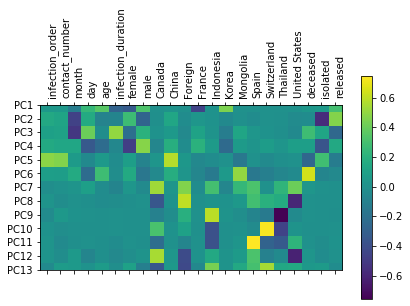

In [34]:
#inspecting importance of each variable

components_range = np.arange(1, n_components+1, 1)

components_names = list(map(lambda x: 'PC' + str(x), components_range))

plt.matshow(pcs.components_,cmap='viridis')

plt.yticks(range(0,n_components), components_names,fontsize=10)

plt.colorbar()
plt.xticks(range(0,len(features.columns)),features.columns,rotation=90,ha='left')
plt.show()

In [35]:
# Higher the values , more is the influence of thse variabes on the Principal Component 


# KMeans Clustering 

In [36]:
pca_df = pd.DataFrame(data = pca.fit_transform(x), columns = components_names)
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,-0.341422,-0.689092,3.438255,0.766374,-0.237834,-1.767565,-0.057311,-0.015085,-0.003734,-0.006195,-0.039249,-0.259778,-0.512355
1,-1.777271,0.508944,2.537452,-1.317163,0.134016,-1.079049,0.100451,-0.037290,-0.002516,-0.003404,-0.006997,-0.325688,-0.051473
2,0.298957,0.398655,-1.400291,3.277041,-0.770948,-0.695420,0.003320,0.076231,-0.019942,-0.008146,0.080907,0.289746,-0.557961
3,-1.110077,-1.990852,1.167787,1.929968,0.005882,-0.850502,-0.222737,0.019243,0.005321,-0.008154,-0.062812,0.054126,-0.431224
4,-2.545926,-0.792817,0.266984,-0.153570,0.377731,-0.161986,-0.064974,-0.002961,0.006540,-0.005364,-0.030560,-0.011785,0.029658


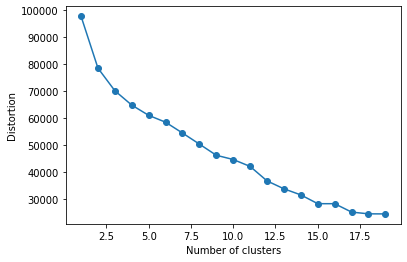

the optimal number of clusters is 12


In [39]:
# Using the elbow test to check optimal number of components

def elbow_test(df, n_init, max_clusters, max_iter):
    distortions = []
    for i in range(1, max_clusters):
        km = KMeans(
            n_clusters=i, init='random',
            n_init=n_init, max_iter=max_iter,
            tol=1e-04, random_state=20
        )
        km.fit(df)
        distortions.append(km.inertia_)
    plt.plot(range(1, max_clusters), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()
    
    kn = KneeLocator(
            range(1, max_clusters),
            distortions,
            curve='convex',
            direction='decreasing',
            interp_method='interp1d',
    )
    return kn.knee

n_clusters = elbow_test(pca_df, 10, 20, 300)
print(f'the optimal number of clusters is {n_clusters}')

In [40]:
# Optimal Number of clusters is 12

In [41]:
# Running KMeans Algo

km = KMeans(n_clusters=n_clusters, random_state=20)

y = km.fit_predict(pca_df)
idx = np.argsort(km.cluster_centers_.sum(axis=1))

lut = np.zeros_like(idx)
lut[idx] = np.arange(n_clusters)

pca_df['cluster'] = lut[km.labels_]
df['cluster'] = lut[km.labels_]

In [42]:
#Saving data

import pickle   
pickle.dump(km, open('kmeans_model.sav', 'wb'))
# Load
km = pickle.load(open('kmeans_model.sav', 'rb'))
pca_df[pca_df['cluster']==3]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,cluster
2190,0.397015,-1.090638,-0.213238,-1.755199,0.640750,0.762600,-0.166506,-0.038975,0.012249,-0.002642,-0.059094,-0.035210,0.362158,3
2198,0.057710,-0.978400,-0.177124,-1.548841,0.579053,0.435218,-0.125960,-0.012345,0.016828,-0.001281,-0.050138,-0.031477,0.290018,3
2200,-0.052108,-0.953026,-0.171120,-1.480107,0.562362,0.348687,-0.118831,-0.004786,0.018058,-0.000902,-0.048181,-0.028987,0.268784,3
2203,0.043982,-0.975229,-0.176373,-1.540249,0.576967,0.424402,-0.125069,-0.011400,0.016982,-0.001234,-0.049893,-0.031165,0.287363,3
2219,-0.010926,-0.962541,-0.173371,-1.505882,0.568621,0.381137,-0.121504,-0.007621,0.017597,-0.001044,-0.048915,-0.029921,0.276747,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5382,1.140657,-0.616926,0.111659,-2.192907,0.939137,0.420534,0.087948,-0.047998,0.053221,-0.011262,-0.054762,-0.127536,0.448923,3
5386,1.354982,-0.528492,0.162385,-2.394276,0.816864,0.279575,0.164705,-0.043309,0.043677,-0.008334,-0.035336,-0.148544,0.443411,3
5387,0.493353,-1.871698,-2.200049,-1.100136,1.143731,1.284764,-0.036745,-0.010047,0.058589,-0.012509,-0.068177,0.183504,0.530771,3
5388,1.905480,-3.131933,-1.352911,0.917711,0.542477,0.556511,-0.197141,0.020439,0.033706,-0.009318,-0.081169,0.257842,0.034385,3


In [43]:
df[df['cluster']==3]

,sex,country,infection_order,contact_number,state,month,day,age,infection_duration,female,...,Korea,Mongolia,Spain,Switzerland,Thailand,United States,deceased,isolated,released,cluster
122,female,Korea,0.0,0.0,isolated,3.0,8.0,79.0,53,1,...,1,0,0,0,0,0,0,1,0,3
130,female,Korea,0.0,0.0,isolated,3.0,9.0,51.0,52,1,...,1,0,0,0,0,0,0,1,0,3
132,female,Korea,0.0,0.0,isolated,3.0,9.0,43.0,52,1,...,1,0,0,0,0,0,0,1,0,3
135,female,Korea,0.0,0.0,isolated,3.0,9.0,50.0,52,1,...,1,0,0,0,0,0,0,1,0,3
151,female,Korea,0.0,0.0,isolated,3.0,9.0,46.0,52,1,...,1,0,0,0,0,0,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3317,female,Korea,0.0,20.0,isolated,3.0,24.0,78.0,37,1,...,1,0,0,0,0,0,0,1,0,3
3321,female,Korea,0.0,14.0,isolated,3.0,29.0,78.0,32,1,...,1,0,0,0,0,0,0,1,0,3
3322,female,Korea,0.0,18.0,isolated,4.0,3.0,78.0,27,1,...,1,0,0,0,0,0,0,1,0,3
3323,male,Korea,0.0,5.0,isolated,4.0,3.0,78.0,27,0,...,1,0,0,0,0,0,0,1,0,3


In [50]:
def draw_scatter(df, col_1, col_2, cluster_column, num_clusters, title):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(col_1)
    ax.set_ylabel(col_2)
    labels = list(range(0,num_clusters))
    colors = plt.cm.Spectral(np.linspace(0, 1, num_clusters))
    axs = []
    for i in labels:
        axs.append(ax.scatter(df[df[cluster_column]==i][col_1], df[df[cluster_column]==i][col_2], cmap=colors[i]))
        ax.legend(axs, labels, loc='center', bbox_to_anchor=(0.92, 0.84), ncol=1)
    plt.show()

<Figure size 1440x720 with 0 Axes>

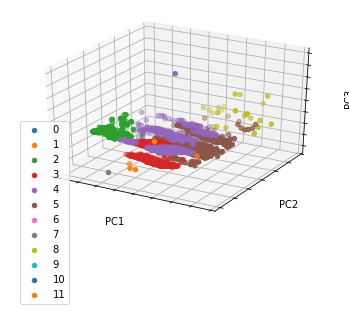

In [51]:
# function for 3d

def create_3d_scatter(df, col_1, col_2, col_3, cluster_column, num_clusters, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title)
    ax.set_xlabel(col_1)
    ax.set_ylabel(col_2)
    ax.set_zlabel(col_3, rotation=90)
    labels = list(range(0,num_clusters))
    colors = plt.cm.Spectral(np.linspace(0, 1, num_clusters))
    axs = []
    for i in labels:
        d = df[df[cluster_column]==i]
        axs.append(ax.scatter(d[col_1], d[col_2], d[col_3], cmap=colors[i]))
    ax.legend(axs, labels, bbox_to_anchor=(0.2, 0.5), ncol=1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    plt.show()
    
plt.figure(figsize=[20,10])    
create_3d_scatter(pca_df, 'PC1', 'PC2', 'PC3', 'cluster', n_clusters, '')

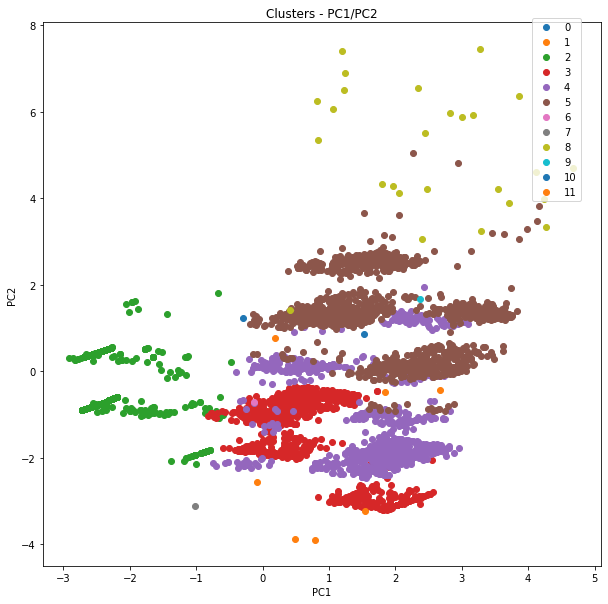

In [52]:
# Checking importance
draw_scatter(pca_df, 'PC1', 'PC2', 'cluster', n_clusters, 'Clusters - PC1/PC2')

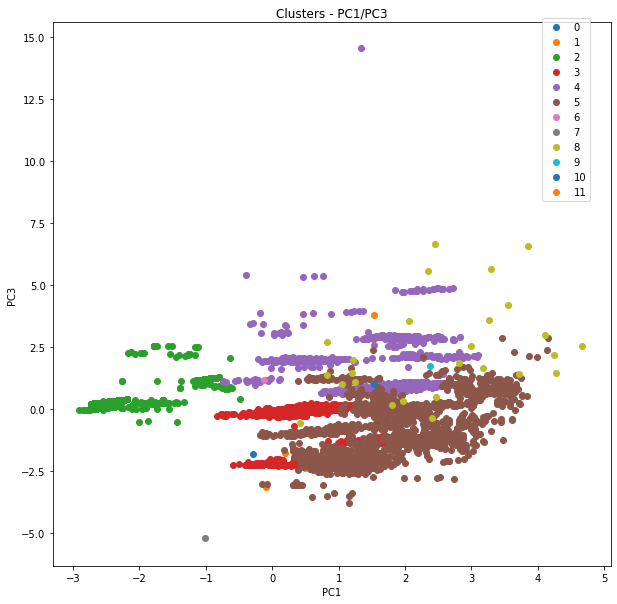

In [53]:
draw_scatter(pca_df, 'PC1', 'PC3', 'cluster', n_clusters, 'Clusters - PC1/PC3')

In [55]:
# Meaning of the PCA's individual
# PC1: men who are not isolated and are not from Korea
# PC2: first months
# PC3: state released

# Conclusions

In [58]:
'''
the clusters found by K-means show that the cases are grouped by certain characteristics among the patients. 
These characteristics are focused on the variables of sex, infection reason, country, and month.
Depending on the value of those variables the data points are distributed among the clusters.

'''


'\nthe clusters found by K-means show that the cases are grouped by certain characteristics among the patients. \nThese characteristics are focused on the variables of sex, infection reason, country, and month.\nDepending on the value of those variables the data points are distributed among the clusters.\n\n'

In [57]:
'''


Cluster 0 :grouped the patients that are women from Korea who contracted the virus in March.

Cluster 1 :contains the other group of women that are from Korea but contracted the virus during other months. 

Cluster 2 :refers to men from France

Cluster 3 :grouped the patients that contracted the virus because they had contact with someone from Italy.

'''

'\n\n\nCluster 0 :grouped the patients that are women from Korea who contracted the virus in March.\n\nCluster 1 :contains the other group of women that are from Korea but contracted the virus during other months. \n\nCluster 2 :refers to men from France\n\nCluster 3 :grouped the patients that contracted the virus because they had contact with someone from Italy.\n\n'